In [183]:
%pip install requests pandas scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 47.6 MB/s eta 0:00:00m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 104.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 112.7 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 112.7 MB/s eta 0:00:00m eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [104]:
import requests;
import pandas as pd
from collections import defaultdict

In [105]:
relevant_parties = ["CDU", "SPD", "GRÜNE", "LINKE", "AfD", "FDP"]
election_map = {"Bundestagswahl": "BTW", "Europawahl": "EUW"}

In [172]:
base_url = "http://r8swgk4cgokosk08kc00swsg.82.165.43.153.sslip.io/"
elections = requests.get(base_url + "election").json()
results = []
for election in elections:
    result = requests.get(base_url + "election/" + str(election["id"]) + "?primary_vote=false").json()
    if election["name"] not in ["Bundestagswahl", "Europawahl"]:
        continue    
    voters = 0
    parties = defaultdict(int)
    
    for region in result["region"]: 
        voters += region["turnout"][0]["voted"]
        for vote in region["votes"]:
            if vote["id"] in relevant_parties:
                idx = relevant_parties.index(vote["id"])
                parties[relevant_parties[idx]] += vote["votes"]
    for (key, value) in parties.items():
        parties[key] = value / voters
    result = {"name": election_map[election["name"]] + str(election["date"]), **parties}
    results.append(result)
    
bs = pd.DataFrame(results).fillna(0)

bund = pd.read_csv("db/results_germany.csv", sep=";")
bund.drop("Sonstige", axis=1, inplace=True)

for party in relevant_parties:
    bund[party] = bund[party].str.replace(",",".").str.rstrip('%').astype('float') / 100.0
# add 0 result for 0 election, as in a linear fn the 0->0 is valid for elections (not taking part)
bund.loc[len(bund)] = ["None", 0, 0, 0, 0, 0, 0]
bs.loc[len(bs)] = ["None", 0, 0, 0, 0, 0, 0]

In [173]:
df = bund.merge(bs, on="name", suffixes=("_bund", "_bs"))
X = df.filter(regex='_bund$')
Y = df.filter(regex='_bs$')
print(df.drop(columns=["name"]).corr())
df


            CDU_bund  SPD_bund  GRÜNE_bund  LINKE_bund  FDP_bund  AfD_bund  \
CDU_bund    1.000000  0.844969    0.452958    0.818609  0.510309  0.049959   
SPD_bund    0.844969  1.000000    0.408529    0.776286  0.597789 -0.045630   
GRÜNE_bund  0.452958  0.408529    1.000000    0.227491  0.410893  0.432967   
LINKE_bund  0.818609  0.776286    0.227491    1.000000  0.501134  0.020633   
FDP_bund    0.510309  0.597789    0.410893    0.501134  1.000000 -0.039618   
AfD_bund    0.049959 -0.045630    0.432967    0.020633 -0.039618  1.000000   
AfD_bs      0.087382 -0.011808    0.407587    0.068817 -0.076304  0.993827   
CDU_bs      0.982687  0.829911    0.409377    0.808590  0.497857  0.025106   
FDP_bs      0.536531  0.601233    0.361712    0.552346  0.964102 -0.073710   
GRÜNE_bs    0.433577  0.435798    0.985946    0.216909  0.440135  0.463424   
LINKE_bs    0.622659  0.557570    0.205071    0.903833  0.396173  0.346898   
SPD_bs      0.884048  0.972417    0.452927    0.748838  0.562549

,name,CDU_bund,SPD_bund,GRÜNE_bund,LINKE_bund,FDP_bund,AfD_bund,AfD_bs,CDU_bs,FDP_bs,GRÜNE_bs,LINKE_bs,SPD_bs
0,EUW2009,0.379,0.208,0.121,0.075,0.110,0.000,0.000000,0.329409,0.094383,0.168234,0.053330,0.269285
1,BTW2009,0.394,0.279,0.092,0.111,0.094,0.000,0.000000,0.289966,0.114476,0.143274,0.099434,0.287357
2,BTW2013,0.415,0.257,0.084,0.086,0.048,0.047,0.035787,0.340296,0.043673,0.123794,0.066957,0.335531
3,EUW2014,0.353,0.273,0.107,0.074,0.034,0.071,0.056270,0.311775,0.027821,0.147883,0.054242,0.334942
4,BTW2017,0.330,0.205,0.089,0.092,0.107,0.126,0.083651,0.290024,0.100125,0.117928,0.093231,0.263847
5,EUW2019,0.289,0.158,0.205,0.055,0.054,0.110,0.068483,0.225905,0.051644,0.280459,0.047393,0.199051
6,BTW2021,0.241,0.257,0.148,0.049,0.115,0.103,0.059141,0.186146,0.100837,0.239788,0.045623,0.304227
7,EUW2024,0.300,0.139,0.119,0.027,0.052,0.159,0.096061,0.223682,0.057632,0.181011,0.031384,0.201804
8,BTW2025,0.286,0.164,0.116,0.088,0.043,0.208,0.133428,0.226163,0.039794,0.179776,0.116310,0.226396
9,None,0.000,0.000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


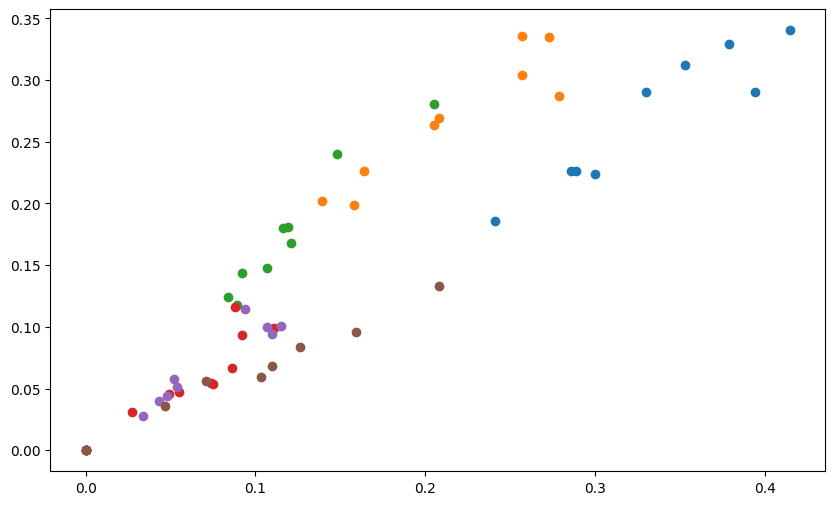

In [186]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for party in ['CDU', 'SPD', 'GRÜNE', 'LINKE', 'FDP', 'AfD']:
    plt.scatter(df[f'{party}_bund'], df[f'{party}_bs'], label=f'{party}')

In [267]:
import numpy as np
from sklearn.kernel_approximation import safe_sparse_dot
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score

X = df.filter(regex='_bund$')
Y = df.filter(regex='_bs$')

model = MultiOutputRegressor(LinearRegression())
model.fit(X,Y)

Y_pred = model.predict(X)
print("R² values")
print(f"model:  \t{r2_score(Y, Y_pred)}")
for i, col in enumerate(Y.columns):
    print(f"{col}: \t{r2_score(Y.iloc[:,i], Y_pred[:,i])}")

R² values
model:  	0.9753553041545354
AfD_bs: 	0.9959108547561862
CDU_bs: 	0.9673596733389698
FDP_bs: 	0.9391483563230574
GRÜNE_bs: 	0.9844173990077121
LINKE_bs: 	0.9843924790078652
SPD_bs: 	0.9809030624934221
